### **To what extent is the growth of nestling blue tits (Cyanistes caeruleus) influenced by competition with siblings?**
#### Project - *Same data, different analysts: variation in effect sizes due to analytical decisions in ecology and evolutionary biology*

Libraries

In [51]:
require (vegan)
require (dplyr)
require (visreg)
require (boot)

Functions

In [52]:
as.num.fact <- function(x) {   #Convert numeric factor into real number
  as.numeric(as.character(x))
}

Data

In [53]:
blue_tit_data=read.csv ("blue_tit_data_updated_2020-04-18.csv")
head(blue_tit_data)

,chick_ring_number,hatch_year,hatch_nest_breed_ID,hatch_Area,hatch_Box,hatch_mom_Ring,hatch_nest_dad_Ring,Extra.pair_paternity,Extra.pair_dad_ring,genetic_dad_ring_.WP_or_EP.,...,net_rearing_manipulation,rear_Cs_at_start_of_rearing,d14_rear_nest_brood_size,number_chicks_fledged_from_rear_nest,Date_of_day14,day_14_tarsus_length,day_14_weight,day14_measurer,chick_sex_molec,chick_survival_to_first_breed_season
,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<int>,<fct>,<int>
1,P804016,2001,201194,C,C130,P803008,P803007,1,.,.,...,3,12,12,12,54,16.6,8.0,1,2,0
2,P804017,2001,201194,C,C130,P803008,P803007,2,.,P803007,...,3,12,12,12,54,15.5,8.1,1,2,0
3,P804018,2001,201167,C,C26,P803005,P803006,2,.,P803006,...,3,12,12,12,54,17.1,10.3,1,2,0
4,P804019,2001,201194,C,C130,P803008,P803007,2,.,P803007,...,3,12,12,12,54,17.6,8.4,1,1,0
5,P804020,2001,201167,C,C26,P803005,P803006,2,.,P803006,...,3,12,12,12,54,16.3,8.1,1,1,0
6,P804021,2001,201194,C,C130,P803008,P803007,2,.,P803007,...,3,12,12,12,54,16.4,8.4,1,2,0


Correct variables types

In [54]:
blue_tit_data=within (blue_tit_data,{
  rear_Cs_at_start_of_rearing = as.num.fact (rear_Cs_at_start_of_rearing)
  number_chicks_fledged_from_rear_nest = as.num.fact(number_chicks_fledged_from_rear_nest)
  rear_d0_rear_nest_brood_size = as.num.fact (rear_d0_rear_nest_brood_size)
  d14_rear_nest_brood_size = as.num.fact (d14_rear_nest_brood_size)
  rear_nest_LD = as.num.fact (rear_nest_LD)
  number_chicks_fledged_from_rear_nest = as.num.fact(number_chicks_fledged_from_rear_nest)
  day_14_tarsus_length = as.num.fact(day_14_tarsus_length)
  day_14_weight = as.num.fact(day_14_weight)
  rear_area=factor (rear_area)
  rear_Box=factor (rear_Box)
  })

Warning message in as.num.fact(rear_Cs_at_start_of_rearing):
"NAs introduzidos por coerção"
Warning message in as.num.fact(number_chicks_fledged_from_rear_nest):
"NAs introduzidos por coerção"
Warning message in as.num.fact(rear_d0_rear_nest_brood_size):
"NAs introduzidos por coerção"
Warning message in as.num.fact(rear_nest_LD):
"NAs introduzidos por coerção"


Subset data to only encompass manipulated broods 

In [55]:
blue_tit_data=subset(blue_tit_data, rear_nest_trt=='5' | rear_nest_trt=='6')

#### **Analysis at the "population level" (nests were considered sampling units)**
#### *Here, I'm going to test the influence of the number of live chicks in the nest (proxy for intraspecific competition) on the average and variance of chick's mass at day 14 (proxy for growth), and on the number of chicks that survived to leave the nest*

Remove variables that we are not going to use for this approach

In [57]:
pop_data=blue_tit_data[,c("rear_Cs_at_start_of_rearing",
                          "d14_rear_nest_brood_size",
                          "number_chicks_fledged_from_rear_nest",
                          "day_14_tarsus_length",
                          "day_14_weight",
                          "rear_nest_LD",
                          "rear_area",
                          "rear_Box"
                          )]

Calculate average and standard deviation for the variables according to each nest box. Note that for some variables, sd will be zero because the variables were measured at the population level (e.g., number_chicks_fledged_from_rear_nest)

In [58]:
pop_data=pop_data %>% 
  group_by(rear_Box, rear_area) %>% 
  summarise_all(.funs = list(Mean= ~ mean(x=.),
                             Sd= ~sd (x=.)))

Explore the correlation between:

* Number of live chicks in the nest at day 14 after hatching (d14_rear_nest_brood_size) and the number of chicks in nest of rearing immediately following experimental chick removals and additions (rear_Cs_at_start_of_rearing). These two variables are proxies for the number of chicks in the nests. 
* Tarsus average length (mm) and average mass of chicks (g) at day 14. These two variables are proxies for the average growth of chicks.   

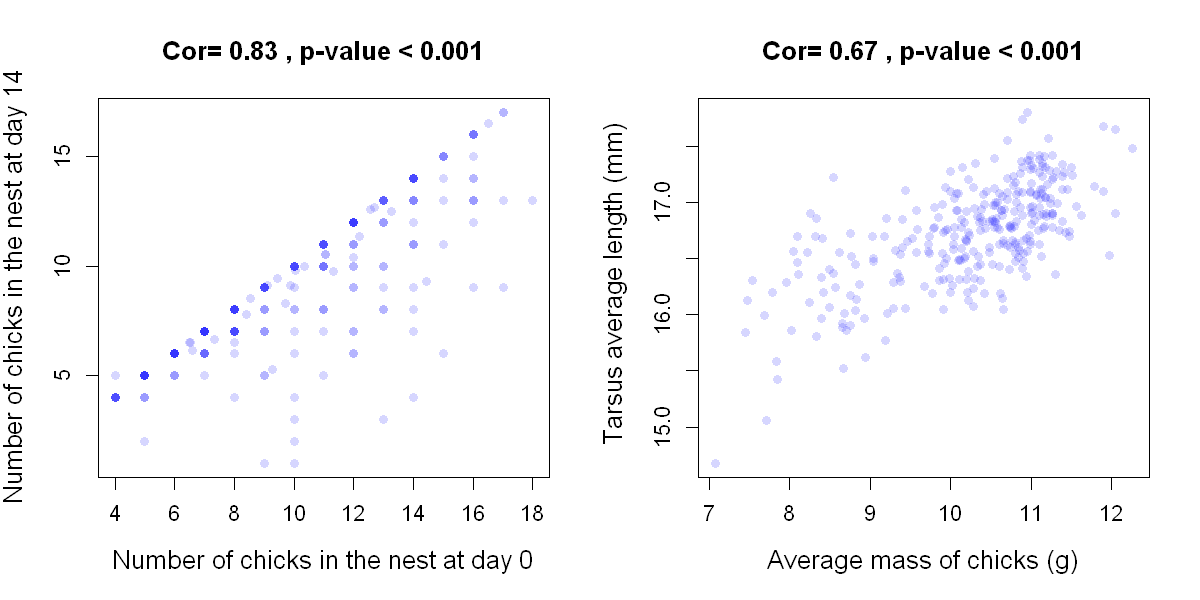

In [63]:
options(repr.plot.width=10, repr.plot.height=5)
par (mfrow=c(1,2))
cor_test1=cor.test (pop_data$d14_rear_nest_brood_size_Mean,
                    pop_data$rear_Cs_at_start_of_rearing_Mean)

plot(d14_rear_nest_brood_size_Mean~rear_Cs_at_start_of_rearing_Mean,
     data=pop_data,main=paste('Cor=' ,round(cor_test1$estimate,2), 
                              ", p-value", ifelse(cor_test1$p.value<0.001,
                                                  "< 0.001",round(cor_test1$p.value,3))),
    ylab= "Number of chicks in the nest at day 14",
    xlab= "Number of chicks in the nest at day 0",
    cex.axis=1.1, cex.lab=1.3,cex.main=1.3,
    pch=16, col=rgb(red=0.2, green=0.2, blue=1.0, alpha=0.2))

cor_test2=cor.test (pop_data$day_14_tarsus_length_Mean,
                    pop_data$day_14_weight_Mean)

plot(pop_data$day_14_tarsus_length_Mean~pop_data$day_14_weight_Mean,
     data=pop_data,main=paste('Cor=' ,round(cor_test2$estimate,2), 
                              ", p-value", ifelse(cor_test2$p.value<0.001,
                                                  "< 0.001",round(cor_test2$p.value,3))),
    ylab=" Tarsus average length (mm)",
    xlab="Average mass of chicks (g)",
    cex.axis=1.1, cex.lab=1.3,cex.main=1.3,
    pch=16, col=rgb(red=0.2, green=0.2, blue=1.0, alpha=0.2))

Both pair of variables are strongly correlated. In order to avoid multicolinearity in my analysis, I will use:
* The number of chicks in nest of rearing immediately following experimental chick removals and additions (rear_Cs_at_start_of_rearing) as a single proxy for intraspecific competition.  
* Mass of chicks at day 14 (day_14_weight_Mean) as a single proxy for chicks growth. 

In [22]:
pop_data= subset(pop_data, select=-c(d14_rear_nest_brood_size_Mean,
                                     day_14_tarsus_length_Mean))
pop_data= na.omit(pop_data) # Remove NAs

Convert some variable into integers and calculate the coefficient of variance of chicks' mass

In [23]:
pop_data$number_chicks_fledged_from_rear_nest=as.integer(pop_data$number_chicks_fledged_from_rear_nest_Mean)
pop_data$rear_Cs_at_start_of_rearing=as.integer(pop_data$rear_Cs_at_start_of_rearing_Mean)
pop_data$day_14_weight_CV= (pop_data$day_14_weight_Sd/pop_data$day_14_weight_Mean)

Now, I'm going to model the influence of the number of chicks in the nests on the response variables: average growth, coefficient variance of average growth, and chicks survivorship. I'm going to conduct univariate models. For each response variable, two models will be conducted: one with a single exploratory variable(the number of chicks in the nests), and another with one exploratory variable (the number of chicks in the nests) and two influential co-variables (rear area and the date of the first egg was laid).

In [24]:
# Average growth model - without co-variables
Model_mean_growth=lm (day_14_weight_Mean~rear_Cs_at_start_of_rearing,
                      data=pop_data)
(Summary_MMeangrowth=summary(Model_mean_growth))


Call:
lm(formula = day_14_weight_Mean ~ rear_Cs_at_start_of_rearing, 
    data = pop_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7336 -0.4292  0.1907  0.5987  1.5074 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 11.69309    0.14878   78.59   <2e-16 ***
rear_Cs_at_start_of_rearing -0.14795    0.01451  -10.20   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8512 on 286 degrees of freedom
Multiple R-squared:  0.2666,	Adjusted R-squared:  0.264 
F-statistic:   104 on 1 and 286 DF,  p-value: < 2.2e-16


In [25]:
# Average growth model - with co-variables
Model_mean_growth_cov=lm (day_14_weight_Mean~rear_Cs_at_start_of_rearing+
                            rear_area+rear_nest_LD_Mean,
                      data=pop_data)
(Summary_MMeangrowth_cov=summary(Model_mean_growth_cov))


Call:
lm(formula = day_14_weight_Mean ~ rear_Cs_at_start_of_rearing + 
    rear_area + rear_nest_LD_Mean, data = pop_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.56056 -0.43994  0.08043  0.54238  1.41939 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 12.198379   0.208007  58.644  < 2e-16 ***
rear_Cs_at_start_of_rearing -0.177285   0.014462 -12.259  < 2e-16 ***
rear_areaC                   0.195125   0.163011   1.197 0.232329    
rear_areaCP                  0.296787   0.205605   1.443 0.150015    
rear_areaE                   0.794289   0.213590   3.719 0.000242 ***
rear_areaMP                  0.204403   0.179060   1.142 0.254633    
rear_areaO                   0.412506   0.154448   2.671 0.008014 ** 
rear_areaP                   0.432071   0.300901   1.436 0.152152    
rear_areaSW                  0.174040   0.170333   1.022 0.307784    
rear_areaW                   0.721884   0.183982   3.924 

In [26]:
#Growth variation model - without co-variables
Model_CV_growth=lm (day_14_weight_CV~rear_Cs_at_start_of_rearing,
                    data=pop_data)
(Summary_MCVgrowth=summary(Model_CV_growth))


Call:
lm(formula = day_14_weight_CV ~ rear_Cs_at_start_of_rearing, 
    data = pop_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.058513 -0.021160 -0.006877  0.010361  0.215143 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 0.0342913  0.0058081   5.904 1.00e-08 ***
rear_Cs_at_start_of_rearing 0.0035607  0.0005665   6.286 1.22e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03323 on 286 degrees of freedom
Multiple R-squared:  0.1214,	Adjusted R-squared:  0.1183 
F-statistic: 39.51 on 1 and 286 DF,  p-value: 1.215e-09


In [27]:
#Growth variation model - with co-variables
Model_CV_growth_cov=lm (day_14_weight_CV~rear_Cs_at_start_of_rearing+
                            rear_area+rear_nest_LD_Mean,
                          data=pop_data)
(Summary_MCVgrowth_cov=summary(Model_CV_growth_cov))


Call:
lm(formula = day_14_weight_CV ~ rear_Cs_at_start_of_rearing + 
    rear_area + rear_nest_LD_Mean, data = pop_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.053169 -0.021353 -0.005527  0.011641  0.205729 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.0246935  0.0085482   2.889  0.00417 ** 
rear_Cs_at_start_of_rearing  0.0040808  0.0005943   6.866 4.33e-11 ***
rear_areaC                   0.0043442  0.0066991   0.648  0.51721    
rear_areaCP                 -0.0047196  0.0084495  -0.559  0.57691    
rear_areaE                  -0.0239446  0.0087777  -2.728  0.00678 ** 
rear_areaMP                 -0.0008386  0.0073586  -0.114  0.90935    
rear_areaO                  -0.0085358  0.0063472  -1.345  0.17978    
rear_areaP                   0.0020569  0.0123658   0.166  0.86801    
rear_areaSW                 -0.0024409  0.0070000  -0.349  0.72757    
rear_areaW                  -0.0120200 

In [28]:
#Survival Model - Without co-variables
Model_mean_Surv= glm (cbind(number_chicks_fledged_from_rear_nest,
                            rear_Cs_at_start_of_rearing)~
                      rear_Cs_at_start_of_rearing,
                      data=pop_data,family="binomial")
paste("In-sample R2 =", 
(1 - (Model_mean_Surv$deviance/Model_mean_Surv$null.deviance))) 
(Summary_MSurv=summary(Model_mean_Surv))

[1] "In-sample R2 = 0.0263927258224279"


Call:
glm(formula = cbind(number_chicks_fledged_from_rear_nest, rear_Cs_at_start_of_rearing) ~ 
    rear_Cs_at_start_of_rearing, family = "binomial", data = pop_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0689  -0.0988   0.1431   0.2807   0.7716  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)  
(Intercept)                  0.016856   0.091781   0.184   0.8543  
rear_Cs_at_start_of_rearing -0.016582   0.008106  -2.046   0.0408 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 158.70  on 287  degrees of freedom
Residual deviance: 154.51  on 286  degrees of freedom
AIC: 1086.9

Number of Fisher Scoring iterations: 3


In [29]:
#Survival Model - With co-variables
Model_mean_Surv_cov=glm (cbind(number_chicks_fledged_from_rear_nest,
                               rear_Cs_at_start_of_rearing)~
                           rear_Cs_at_start_of_rearing+
                           rear_area+rear_nest_LD_Mean,
                         data=pop_data,family="binomial")
paste("In-sample R2 =",
(1 - (Model_mean_Surv_cov$deviance/ Model_mean_Surv_cov$null.deviance))) 
(Summary_MSurv_cov=summary(Model_mean_Surv_cov))

[1] "In-sample R2 = 0.0484663323243457"


Call:
glm(formula = cbind(number_chicks_fledged_from_rear_nest, rear_Cs_at_start_of_rearing) ~ 
    rear_Cs_at_start_of_rearing + rear_area + rear_nest_LD_Mean, 
    family = "binomial", data = pop_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0265  -0.1097   0.1307   0.2745   0.8892  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)  
(Intercept)                  0.067605   0.132059   0.512   0.6087  
rear_Cs_at_start_of_rearing -0.020870   0.008572  -2.435   0.0149 *
rear_areaC                   0.087367   0.096083   0.909   0.3632  
rear_areaCP                  0.080725   0.129610   0.623   0.5334  
rear_areaE                   0.114763   0.120664   0.951   0.3416  
rear_areaMP                  0.074146   0.108325   0.684   0.4937  
rear_areaO                   0.084328   0.093439   0.902   0.3668  
rear_areaP                   0.125516   0.171133   0.733   0.4633  
rear_areaSW                  0.014338   0.105899   0.1

Visualize the effect of the number of chicks in the nests on our response variables according to the models created. 

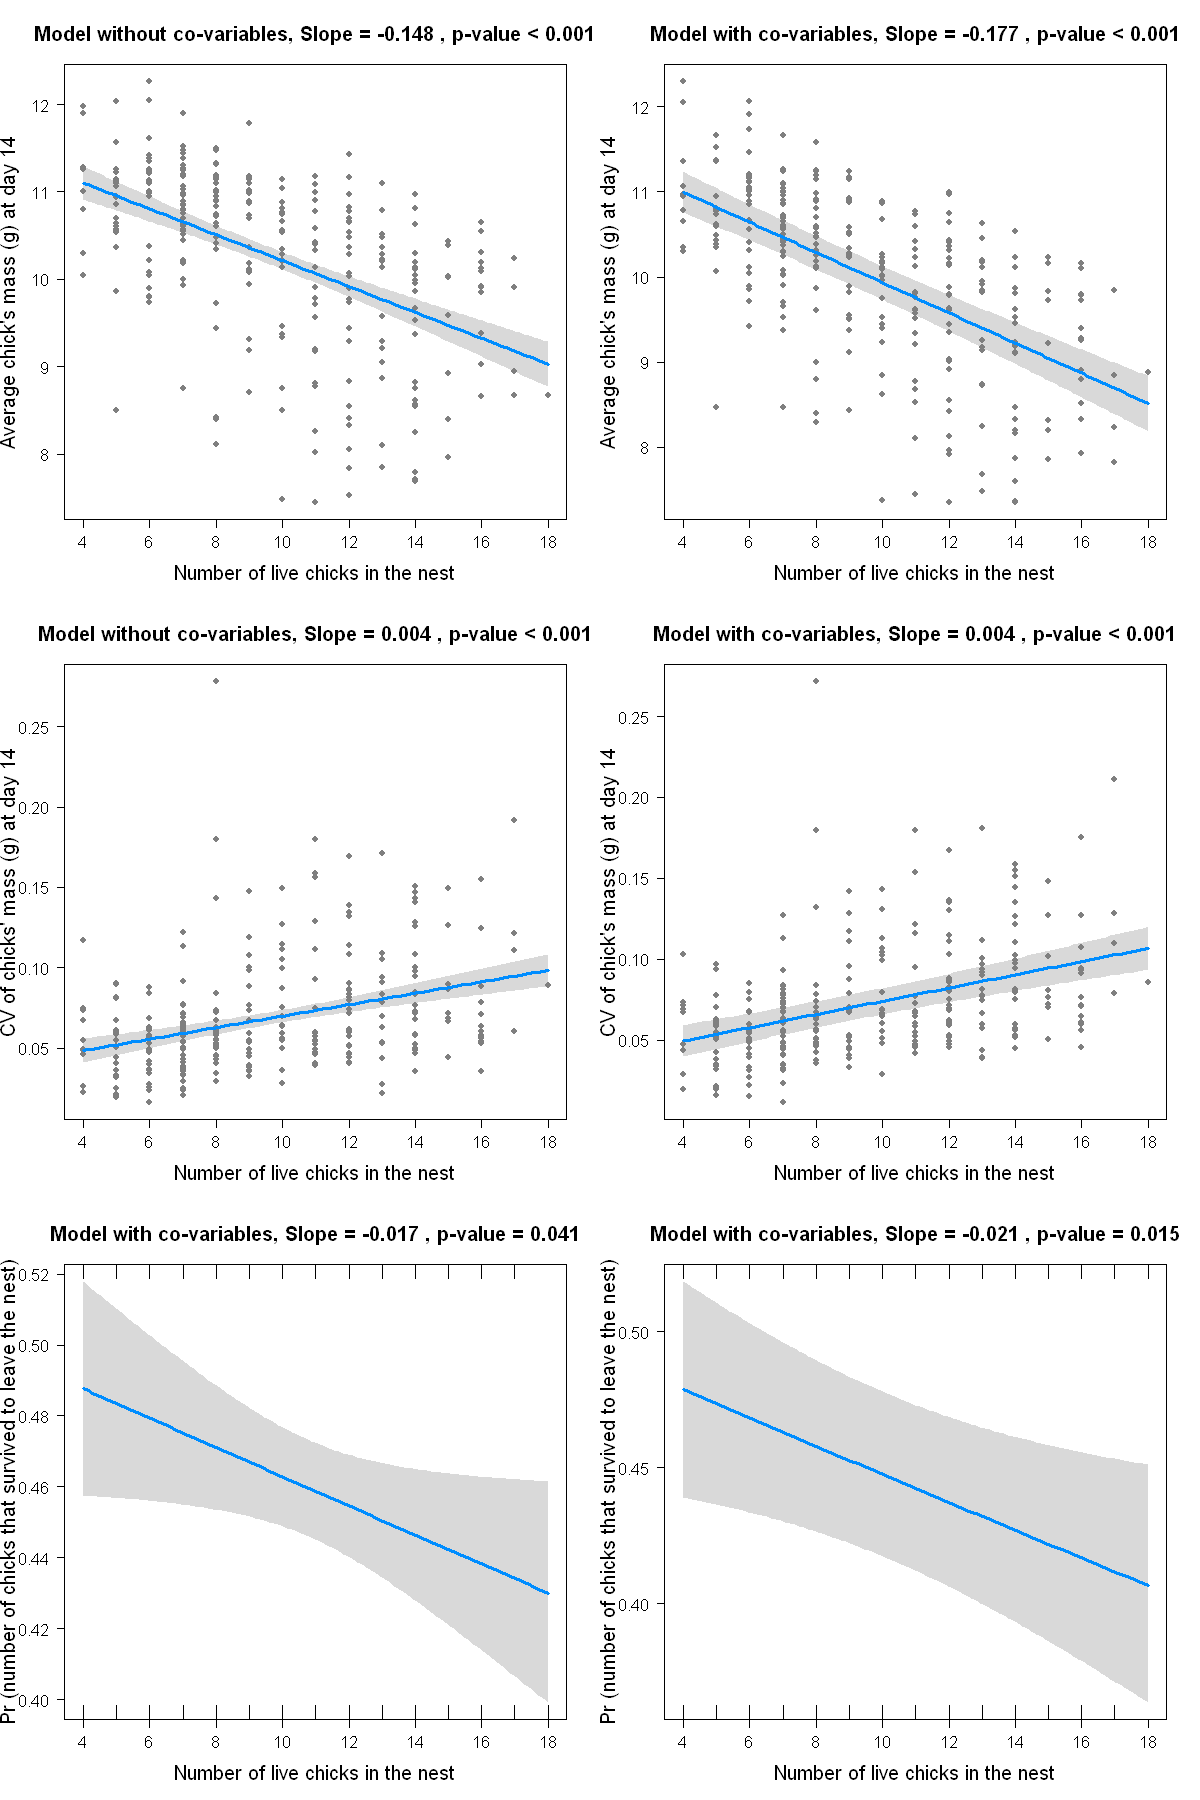

In [49]:
options(repr.plot.width=10, repr.plot.height=15)
par(mfrow=c(3,2))

# Average growth models
visreg(Model_mean_growth, xlab="Number of live chicks in the nest", 
       ylab="Average chick's mass (g) at day 14",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model without co-variables,",
                  "Slope =", round(Summary_MMeangrowth$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MMeangrowth$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MMeangrowth$coefficients[2,4],3))))
       ) 



visreg(Model_mean_growth_cov,xvar="rear_Cs_at_start_of_rearing", 
       xlab="Number of live chicks in the nest", 
       ylab="Average chick's mass (g) at day 14",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model with co-variables,",
                  "Slope =", round(Summary_MMeangrowth_cov$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MMeangrowth_cov$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MMeangrowth_cov$coefficients[2,4],3))))
       )

# Growth variation models
visreg(Model_CV_growth, xlab="Number of live chicks in the nest", 
       ylab="CV of chicks' mass (g) at day 14",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model without co-variables,",
                  "Slope =", round(Summary_MCVgrowth$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MCVgrowth$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MCVgrowth$coefficients[2,4],3))))
)

visreg(Model_CV_growth_cov,xvar="rear_Cs_at_start_of_rearing", 
       xlab="Number of live chicks in the nest", 
       ylab="CV of chick's mass (g) at day 14",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model with co-variables,",
                  "Slope =", round(Summary_MCVgrowth_cov$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MCVgrowth_cov$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MCVgrowth_cov$coefficients[2,4],3))))
       )

# Survival models
visreg(Model_mean_Surv,scale="response",rug=2,ylab="",
       xlab="Number of live chicks in the nest",
       ylab="Pr (number of chicks that survived to leave the nest)",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model with co-variables,",
                  "Slope =", round(Summary_MSurv$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MSurv$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MSurv$coefficients[2,4],3))))
       )

visreg(Model_mean_Surv_cov,scale="response",rug=2,
       xvar="rear_Cs_at_start_of_rearing",
       xlab="Number of live chicks in the nest",
       ylab="Pr (number of chicks that survived to leave the nest)",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model with co-variables,",
                  "Slope =", round(Summary_MSurv_cov$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MSurv_cov$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MSurv_cov$coefficients[2,4],3))))
                  )

These results indicate that intraspecific competition has a significant effect on the growth (average and variation) and survivorship of nestling blue tits. These effects were still significant after accounting for potential confounding variables related to environmental conditions. However, it should be highlighted that the relationship among the variables is usually weak, especially for growth variance and survivorship.